In [1]:

import plotly.graph_objects as go
from collections import defaultdict, Counter
import matplotlib.colors as mcolors

from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, recall_score, precision_score,mean_squared_error, f1_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize
from scipy.sparse import *
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.models.word2vec import Word2Vec


import matplotlib.cm as cm

from itertools import permutations, cycle, islice
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
#from interpret import show
#from interpret.perf import ROC
#from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier
#from interpret.blackbox import ShapKernel
#import shap
#from xgboost import XGBClassifier
#from interpret.data import ClassHistogram

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from data_loader import *
from utils import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt# Noise block
import numpy as np
from torch.utils.tensorboard import SummaryWriter
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport utils

In [2]:
%%time
Dataset()
Users()
CityStats()

Loading pickled data
5197222 transactions loaded
Filtering users: 51143 out of 165579 remain. Percentage of transactions covered: 81.31
Wall time: 2min


# Embeddings block

In [3]:
%%time
if os.path.exists(EMBEDDING_PATH):
    with open(EMBEDDING_PATH, 'rb') as f:
        embeddings_dict = pickle.load(f)
else:
    dataset = [Transaction.to_sentence(t) for t in Dataset().transactions]
    print('created_dataset')
    gensim_skipgram = Word2Vec(dataset,vector_size=300, window=100, min_count=1, workers=8,epochs=5,sample=1e-4, shrink_windows=False,) 
    with open(EMBEDDING_PATH, 'wb') as f:
        pickle.dump(gensim_skipgram.wv, f)
    embeddings_dict = gensim_skipgram.wv
    del dataset
print(Dataset().barcode_to_product['7290004127329'].name)
for x, y in embeddings_dict.most_similar('7290004127329'):
    print(Dataset().barcode_to_product[x].name, y)

קוטג תנובה מהדרין 5% 250ג
קוטג תנובה 5% בדץ 250ג 0.7334272265434265
קוטג תנובה 9% 250ג 0.6938319802284241
קוטג שטראוס 5% עם סידן 250ג 0.6859591007232666
קוטג תנובה 3% 250 ג 0.6783396005630493
טרה קוטג 5% 100% רכיבים טבעיים 250 גר 0.6145057678222656
טרה קוטג 5% 100% רכיבים טבעיים 375 גר 0.5948288440704346
קוטג תנובה בד"צ 9% 250ג 0.5082301497459412
קוטג שטראוס 5% 400ג 0.46551740169525146
קוטג בקטנה 5% 100ג 0.43497148156166077
טרה קוטג 3% 100% רכיבים טבעיים 250 גר 0.4226052165031433
Wall time: 1.07 s


In [5]:
to_show = 60
products = sorted(Dataset().products, key=lambda x: x.usages, reverse=True)[:5000]
product_vectors = np.vstack([embeddings_dict[x.barcode] for x in products])
decompose(product_vectors[:300], 
          show=to_show, 
          hue=[smart_inverse(x.hierarchy_names[2]) for x in products[:to_show]], 
          annotations=[smart_inverse(x.name) for x in products[:to_show]])

KeyboardInterrupt: 

In [5]:
category_counts = Counter([x.hierarchy_names[-2][2:] for x in products])
filtered_cats= [x for x,y in category_counts.items() if y>25]
len(filtered_cats)
for cat in filtered_cats:
    cat_products = [x for x in products if x.hierarchy_names[-2][2:] == cat]
    cat_vectors = np.vstack([embeddings_dict[x.barcode] for x in cat_products])
    cat_vectors = normalize(cat_vectors, axis=1)
    sim_matrix = cat_vectors.dot(cat_vectors.T)
    n = sim_matrix.shape[0]
    similarity = (sim_matrix.sum() - n)/(n**2-n)
    print(cat, similarity)

חטיפי בוטנים 0.15461168867169003
מעדני חלב + קצפת 0.16099937531629555
יוגורט בטעמים/תוספות 0.10228342774314915
חטיפי חיטה 0.10237456072727448
חטיפים מלוחים לילדים 0.16210436698717948
חטיפי ציפס 0.1602718060879359
משקאות חלב  משפחתי 0.21544336389612267
יוגורט לבן 0.2752764233313371
עוגיות מצופות פרימיום 0.2982571158993278
פסטה קצרה 0.10903648551498187
לחם מיוחד ארוז 0.26273512566226653
משקה חלב אישי קרטון/בקבוק 0.2952369811042907
פיתות ארוזות 0.11091359969108336
משק"ל משפחתי 1ל ומעלה 0.143704984793852
דגני ילדים 0.20576138325019822
נוזל לשטיפת כלים 0.18054151637579804
שוקולד חלב תוספות\ממולא 0.25455688799499837
יוגורט בטעמים דיאט 0.2685599693885216
שמפו 401-749 0.18285852191091953
כוסות חד פעמי 0.13174512146641967
מסטיק לל"ס בקבוקונים 0.23620572212414864
מרכך כביסה מרוכז 0.2683920630796708
חטיפי דגנים מבוגרים מארז 0.25151824951171875
סבון לגוף מ-501 מ"ל- 750 מ"ל 0.17095720244616996


Counter({-1: 5, 0: 9, 1: 13})

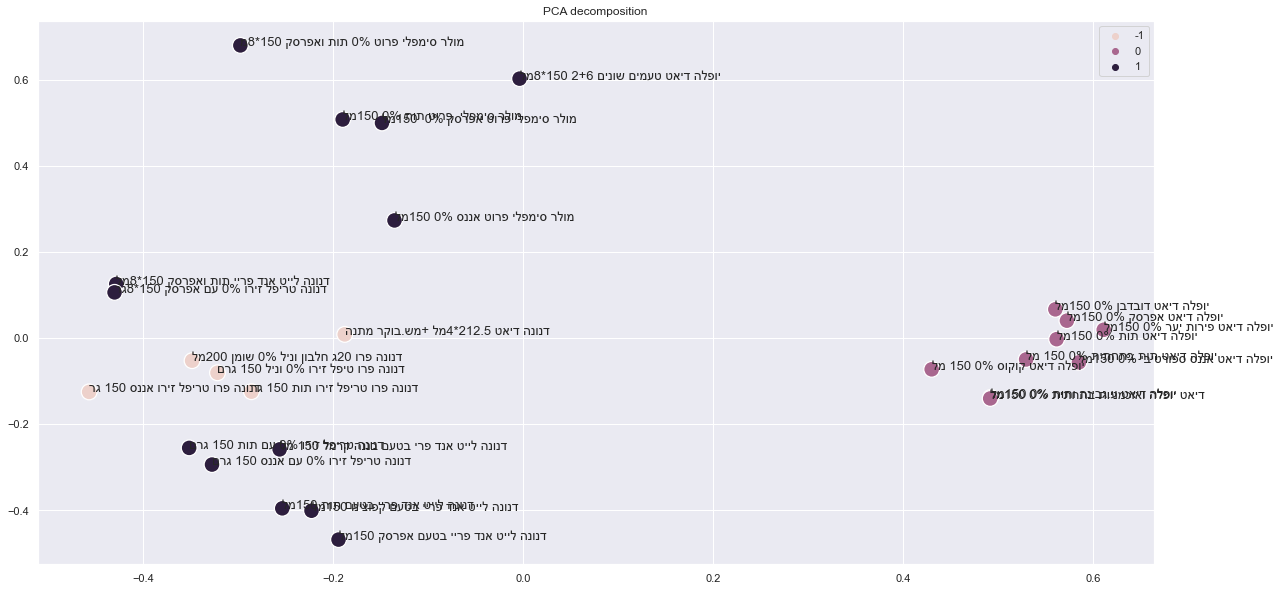

In [6]:
cat_products = [x for x in products if x.hierarchy_names[-2][2:] == "יוגורט בטעמים דיאט"]
cat_vectors = np.vstack([embeddings_dict[x.barcode] for x in cat_products])
cat_vectors = normalize(cat_vectors, axis=1)
sim_matrix = cat_vectors.dot(cat_vectors.T)
n = sim_matrix.shape[0]
clusterer = DBSCAN(eps=0.6, min_samples=3, metric='cosine', algorithm='auto', leaf_size=100)
y = clusterer.fit_predict(cat_vectors)
decompose(cat_vectors, annotations=[smart_inverse(x.name) for x in cat_products], hue=y)
Counter(y)

# City stats block

## hello

In [7]:
stats_df = pd.DataFrame(CityStats().stats_df)
stats_df = stats_df[stats_df.n_users > 30]
clalit_cities = pd.read_csv('./stats/cities_clalit.csv')
clalit_cities.columns=['city', 'district']
clalit_cities.city = clalit_cities.city.map(lambda x: convert_city_name(x))
city_to_region = {x:translate_district(y) for x,y in clalit_cities.values}
stats_df['district'] = stats_df.index.map(lambda x: city_to_region.get(x, 'Unknown'))

In [8]:
"""def calculate_averages():
    clalit_splits = pd.read_csv('splits_clean.csv')
    clalit_splits=clalit_splits[clalit_splits.test_name != 'znb']
    average_values = clalit_splits.groupby(['sector','test_name','age']).mean()
    clalit_splits = clalit_splits.set_index(['age', 'test_name'])
    tables = {}
    for sector in ['haredi', 'general']:
        for district in clalit_splits.district.unique():
            my_table = np.zeros((9, 45))
            columns_names = []
            cs = clalit_splits[(clalit_splits.sector==sector) & (clalit_splits.district==district)]
            for i, age in enumerate(sorted(clalit_splits.index.get_level_values(0).unique())[:-1]):
                for j, test_name in enumerate(sorted(clalit_splits.index.get_level_values(1).unique())):
                    if i == 0:
                        columns_names += [test_name+'_low', test_name+'_norm', test_name+'_high']
                    if (age, test_name) in cs.index:
                        v = cs.loc[(age, test_name)].values[-3:]
                    else:
                        v = average_values.loc[('general',test_name,age)].values
                    my_table[i, 3*j:3*j+3] = v
            tables[sector,district] = my_table
    c_list = []
    values = []
    for row in stats_df.iterrows():
        if row[1]['district'] == 'Unknown':
            continue
        c_list.append(row[0])
        row = row[1]
        population_proportions = row.values[2:11]
        v = (1-row.haredim/100)*population_proportions.dot(tables['general',district]) + (row.haredim/100)*population_proportions.dot(tables['haredi',row.district])
        values.append(v)
    values = np.vstack(values)


    #age_distribution = stats_df.loc[cities_to_join, stats_df.columns[2:11]].values/100
    stats_df[columns_names] = pd.DataFrame([[np.nan]*len(columns_names)])
    stats_df.loc[c_list, columns_names] = values"""
stats_df.head()

,n_users,population,00-03,04-08,09-13,14-18,19-21,22-30,31-50,51-65,66+,haredim,diabetes_ratio,salary,socio,periphery,non_jews_ratio,user_percentage,district
CITY,,,,,,,,,,,,,,,,,,,
אבן יהודה,43,30662,11.248451,11.088644,8.495858,6.884743,4.471333,15.165351,21.922901,12.412758,8.303437,0.0,46.38,13553.54,1.54,1.20,1.7,0.140239,Unknown
אופקים,349,18972,7.605946,8.728653,7.073582,5.898166,3.779254,12.007168,25.653595,16.360953,12.929580,0.0,68.52,6462.00,-0.70,-0.49,7.0,1.839553,South
אור יהודה,392,52299,5.933192,7.434177,6.763036,6.397828,4.263944,14.526090,28.665940,16.382722,9.642632,8.0,66.58,7859.00,0.17,2.48,2.1,0.749536,Dan - Petach Tikva
אור עקיבא,222,48763,11.881960,16.157743,16.920616,14.102906,6.051720,8.467486,20.870332,4.025593,1.511392,0.0,67.70,7343.00,-0.02,0.40,7.8,0.455263,Sharon - Shomron
אזור,119,20540,6.139241,7.517040,6.499513,4.795521,5.428432,20.243427,22.697176,15.516066,11.153846,0.0,56.37,9128.50,0.66,2.90,5.8,0.579357,Unknown


In [9]:
small_city_list = stats_df[(stats_df.district != 'Unknown') & (stats_df.district != 'Eilat') & (stats_df.n_users > 200)].index.values
city_list =  stats_df[(stats_df.district != 'Unknown') & (stats_df.district != 'Eilat')].index.values
region_list = [city_to_region[y] for y in city_list]
len(city_list)

74

In [10]:
user_embeddings = np.vstack([embeddings_dict[x] for x,y in Users().active_users_cities.items() if y in small_city_list])
#user_embeddings = normalize(user_embeddings, axis=1)

city_embeddings = np.vstack([embeddings_dict[x] for x in city_list])
#city_embeddings = normalize(city_embeddings, axis=1)

user_cities = [y for x,y in Users().active_users_cities.items() if y in small_city_list]
user_regions = [city_to_region[y] for y in user_cities]

In [ ]:
"""from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='tensorboard')
writer.add_embedding(product_vectors[:500], metadata=[x.hierarchy_names for x in products[:500]], metadata_header=['TYPE', 'CLASS', 'CAT', 'SUB-CAT', 'NAME'], tag='products')

writer.add_embedding(user_embeddings[:5000], metadata=list(zip(user_cities[:5000], user_regions[:5000])), metadata_header=['CITY', 'REGION'], tag='users')

writer.add_embedding(city_embeddings, metadata=list(zip(city_list,region_list)), metadata_header=['CITY', 'REGION'], tag='cities')

writer.close()

%load_ext tensorboard

%tensorboard --logdir=tensorboard"""

# Clalit data

In [9]:
clalit_splits = pd.read_csv('./stats/splits_district_only.csv')
clalit_splits=clalit_splits[clalit_splits.test_name != 'znb']
clalit_splits=clalit_splits[clalit_splits.district != 'Eilat']
clalit_splits.loc[clalit_splits.age == '9-13','age']  = '09-13'
norms = {}
for test in clalit_splits.test_name.unique():
    for district in clalit_splits.district.unique():
        cs = clalit_splits[(clalit_splits.test_name == test) & (clalit_splits.district == district)].sort_values('age').normal_pct.values
        norms[(test,district)] = cs[:8]
        

In [12]:
stats_df.head()

,n_users,population,00-03,04-08,09-13,14-18,19-21,22-30,31-50,51-65,66+,haredim,diabetes_ratio,salary,socio,periphery,non_jews_ratio,user_percentage,district
CITY,,,,,,,,,,,,,,,,,,,
אבן יהודה,43,30662,11.248451,11.088644,8.495858,6.884743,4.471333,15.165351,21.922901,12.412758,8.303437,0.0,46.38,13553.54,1.54,1.20,1.7,0.140239,Unknown
אופקים,349,18972,7.605946,8.728653,7.073582,5.898166,3.779254,12.007168,25.653595,16.360953,12.929580,0.0,68.52,6462.00,-0.70,-0.49,7.0,1.839553,South
אור יהודה,392,52299,5.933192,7.434177,6.763036,6.397828,4.263944,14.526090,28.665940,16.382722,9.642632,8.0,66.58,7859.00,0.17,2.48,2.1,0.749536,Dan - Petach Tikva
אור עקיבא,222,48763,11.881960,16.157743,16.920616,14.102906,6.051720,8.467486,20.870332,4.025593,1.511392,0.0,67.70,7343.00,-0.02,0.40,7.8,0.455263,Sharon - Shomron
אזור,119,20540,6.139241,7.517040,6.499513,4.795521,5.428432,20.243427,22.697176,15.516066,11.153846,0.0,56.37,9128.50,0.66,2.90,5.8,0.579357,Unknown


In [14]:

distances = {}
city_list = []
for row in stats_df.iterrows():
    name, series = row[0], row[1]
    if series.district == 'Unknown' or series.district == 'Eilat' or series.haredim > 40 or series.n_users < 200:
        continue
    city_list.append(name)
    ages_v = series.values[2:10]
    orig_district = series.district
    for test in clalit_splits.test_name.unique():
        for district in clalit_splits.district.unique():
            distances[test, name, district] = ages_v.dot(np.abs(norms[test,district] - norms[test,orig_district]))
city_list = sorted(city_list, key=lambda x: city_to_region[x])

In [18]:

health_distances = np.zeros((len(city_list), len(city_list)))
for i, c1 in enumerate(city_list):
    d1 = city_to_region[c1]
    
    for j, c2 in enumerate(city_list):
        d2 = city_to_region[c2]
        if d1 == d2:
            health_distances[i,j] = 0
            continue
        distance = 0
        for test in clalit_splits.test_name.unique():
            distance += distances[test, c1, d2]
            distance += distances[test, c2, d1]
        health_distances[i,j] = distance
mean = health_distances.mean()
health_distances /= mean
health_distances.shape

(48, 48)

In [19]:

            
#def city_distance_by_age(c1, c2):
from scipy.stats import wasserstein_distance
from sklearn.metrics import pairwise_distances
ages = CityStats().population_df.loc[city_list].values[:, 2:78].astype(float)
totals = CityStats().population_df.loc[city_list].values[:, 78].astype(float)

ages = np.divide(ages.T,totals).T
age_distances = pairwise_distances(ages, metric=wasserstein_distance)
age_distances /= age_distances.mean()
mean_ages = ages.dot(np.array(list(range(76))))


city_embeddings = np.vstack([embeddings_dict[x] for x in city_list])
city_embeddings_normalized = normalize(city_embeddings, axis=1)
food_distances = 2-2*city_embeddings_normalized.dot(city_embeddings_normalized.T)

food_distances *= (food_distances > 0)
food_distances.shape, food_distances.min()


((48, 48), -0.0)

In [20]:
regions = sorted({city_to_region[x] for x in city_list})
health_distances_reg = np.zeros((len(city_list), len(regions)))
for i, c1 in enumerate(city_list):
    for j, d2 in enumerate(regions):
        d1 = city_to_region[c1]
        if d1 == d2:
            health_distances_reg[i,j] = 0
            continue
        distance = 0
        for test in clalit_splits.test_name.unique():
            distance += distances[test, c1, d2]
        health_distances_reg[i,j] = distance
health_distances_reg /= mean

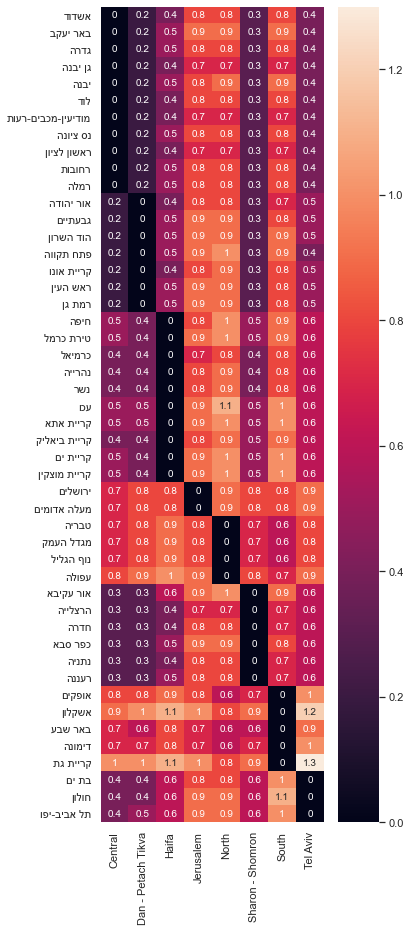

In [21]:
plt.figure(figsize=(5,15))
df = pd.DataFrame(health_distances_reg.round(1), columns=regions, index=[smart_inverse(x) for x in city_list])
sns.heatmap(df, annot=True)
plt.savefig('./img/Health_regions.png')

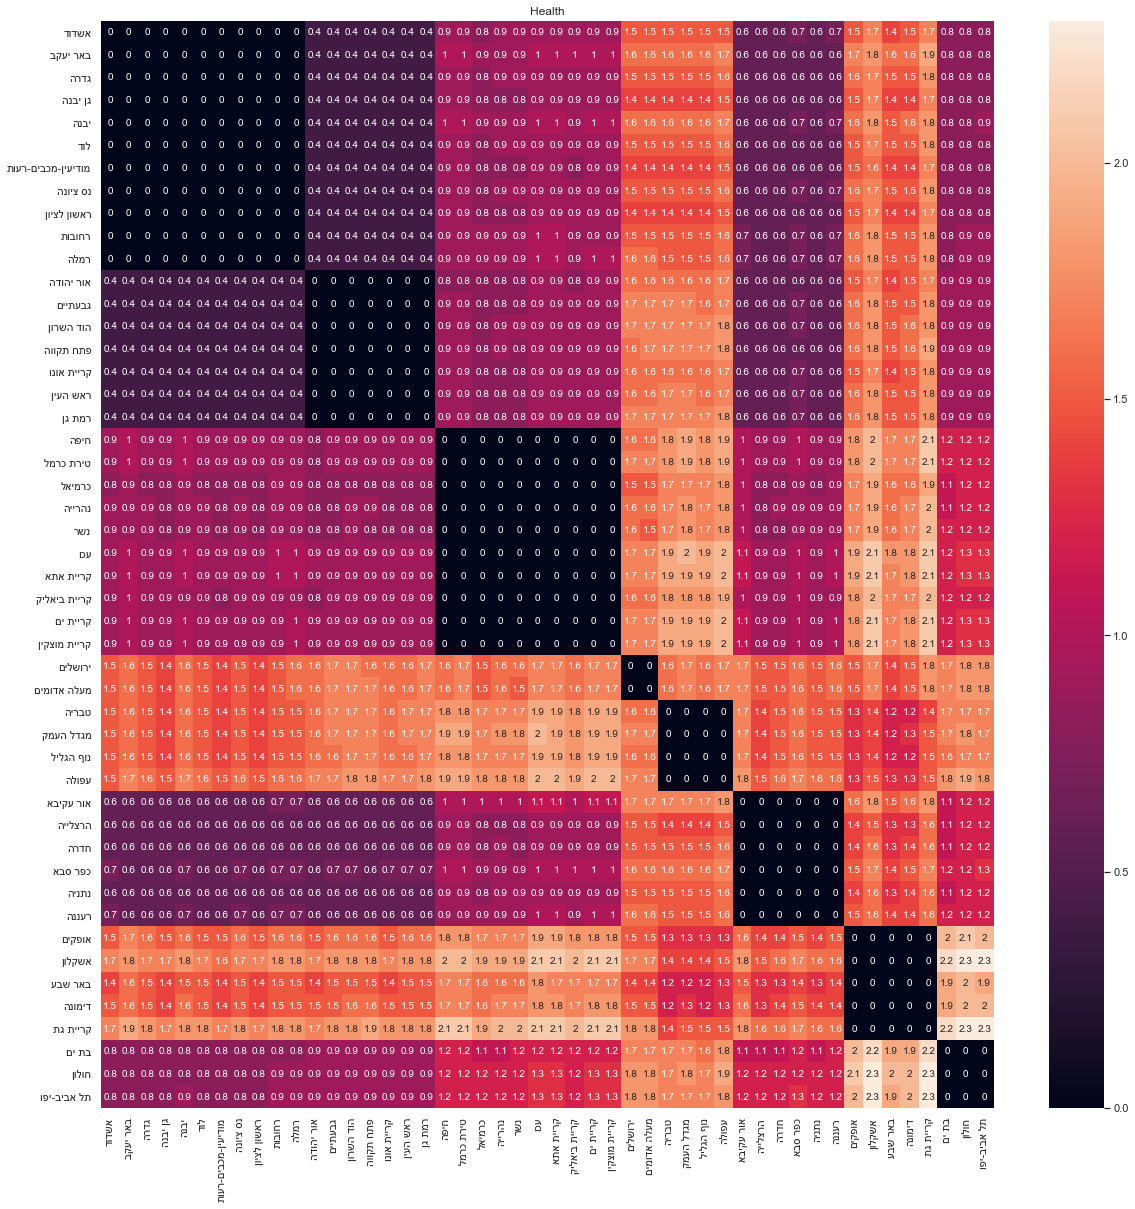

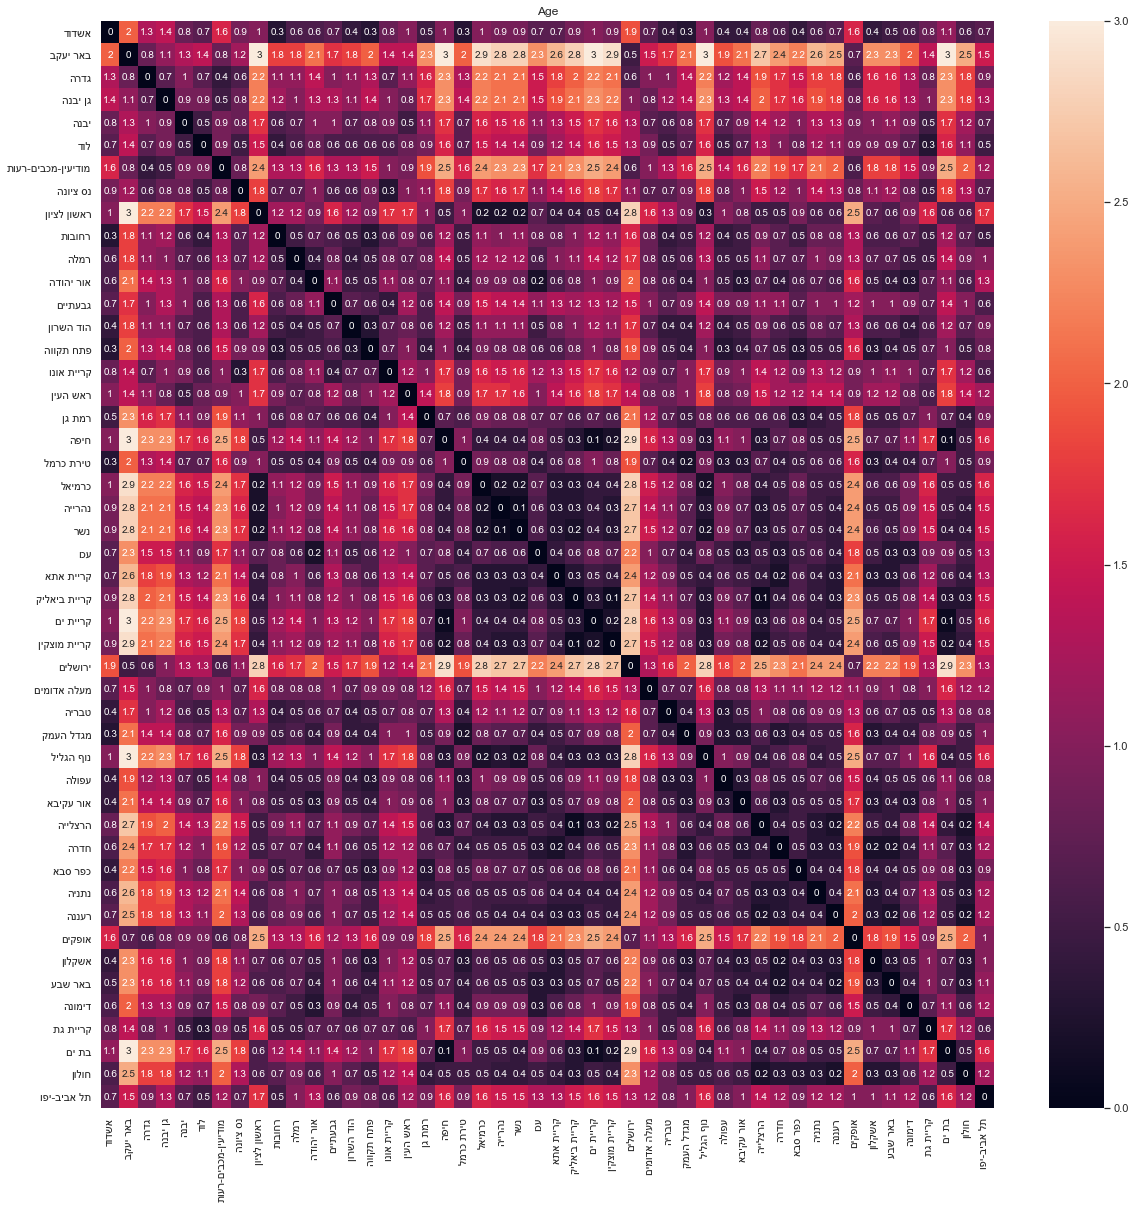

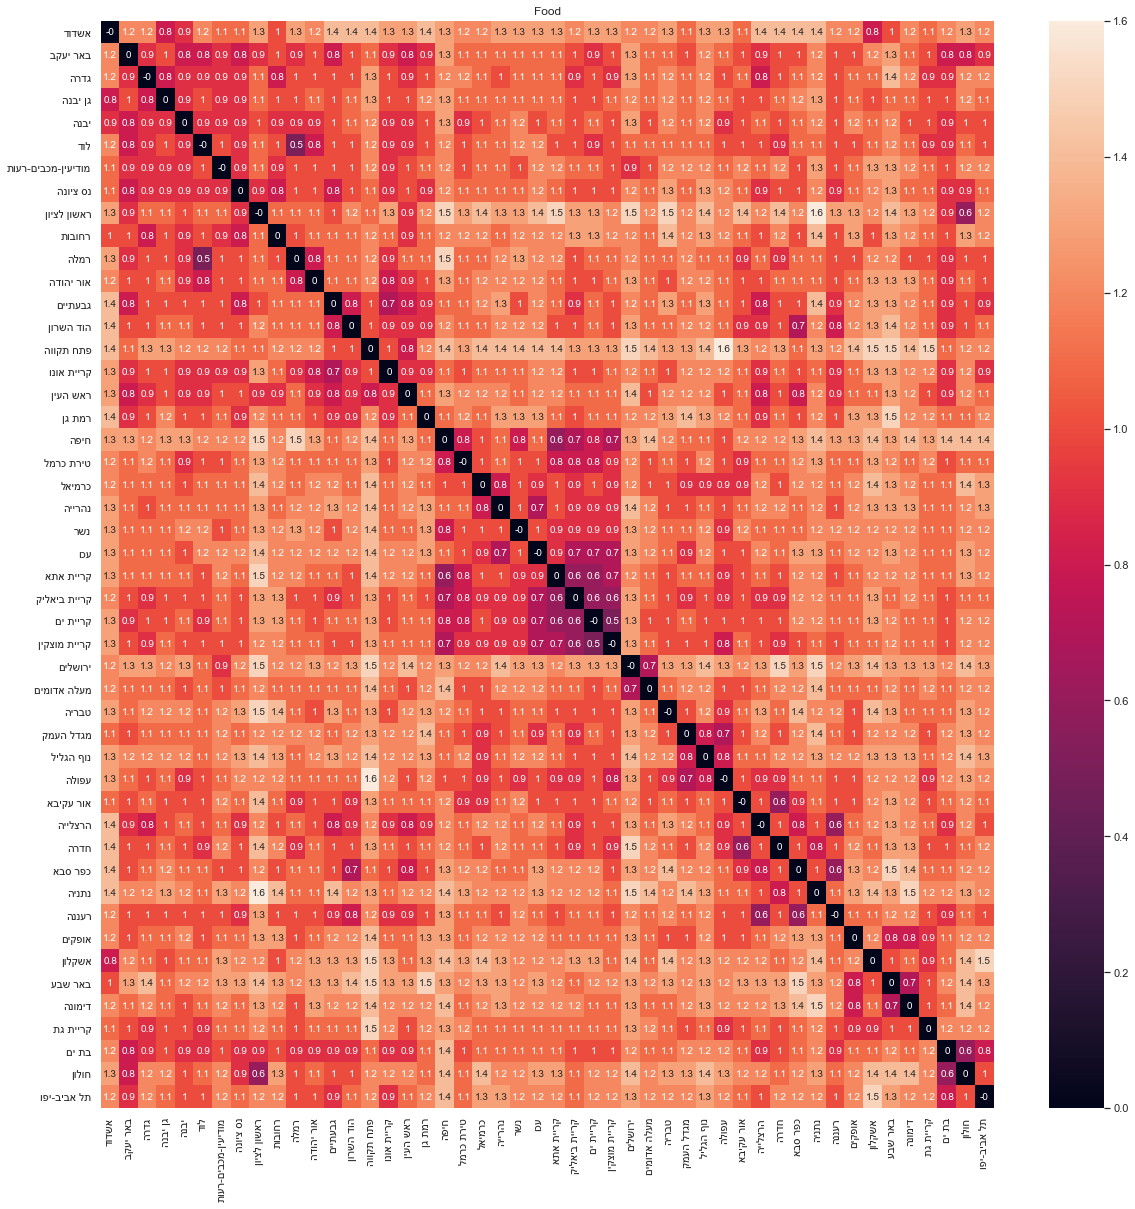

In [22]:
plt.figure(figsize=(20,20))
df = pd.DataFrame(health_distances.round(1), columns=[smart_inverse(x) for x in city_list], index=[smart_inverse(x) for x in city_list])
p = sns.heatmap(df, annot=True)
p.set_title('Health')
plt.savefig('./img/health.png')
plt.figure(figsize=(20,20))
df = pd.DataFrame(age_distances.round(1), columns=[smart_inverse(x) for x in city_list], index=[smart_inverse(x) for x in city_list])
p = sns.heatmap(df, annot=True)
p.set_title('Age')
plt.savefig('./img/age.png')
plt.figure(figsize=(20,20))
df = pd.DataFrame(food_distances.round(1), columns=[smart_inverse(x) for x in city_list], index=[smart_inverse(x) for x in city_list])
p = sns.heatmap(df, annot=True)
p.set_title('Food')
plt.savefig('./img/food.png')

# Food distance:
### L2 distance between embeddings

# Age distance:
### Wasserstein distance, also known as the earth mover’s distance, since it can be seen as the minimum amount of “work” required to transform $u$ into $v$, where “work” is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

# Health distance:

### <b>Assume we can "move" city A from district A to district B, completely replacing all health statistics. How many people will change their health status according to test T? </b>
#### $d(cityA,districtB) = \sum_{test \ T} \sum_{ages \ in \ A} \ (p^A_{age} \cdot |normal_T A - normal_T B|)$


### <b>Now imagine we swap districts of city A and B:</b>
#### $d(cityA,cityB) = d(cityA,distictB) + d(cityB,districtA)$


# Total Distance:
### We scale distances of each type to have average ~1, and then take weighted sum: $d(A,B)=w_1 \cdot d_{age} + w_2 \cdot d_{food} + w_3 \cdot d_{health}$

### <b>Problem: citites in the same district receive distance = 0</b>
#### Current solution: for cities in the same district we set heatlh distance as average between food and age distances

In [23]:
def get_distance(food_weight=1, age_weight=0, health_weight=2):
    total_distance = np.zeros((len(city_list), len(city_list)))

    for i, c1 in enumerate(city_list):
        d1 = city_to_region[c1]
        for j, c2 in enumerate(city_list):
            d2 = city_to_region[c2]
            if i == j:
                total_distance[i,j] = 0
            elif d1 == d2:
                total_distance[i,j] = food_distances[i,j]*(food_weight+health_weight/2)+age_distances[i,j]*(age_weight+health_weight/2)
            else:
                total_distance[i,j] = food_distances[i,j]*food_weight+age_distances[i,j]*age_weight + health_distances[i,j]*health_weight
    return total_distance

In [ ]:

#decompose(food_distances, init='random', metric='precomputed',  title='by sales', tsne=True, hue=stats_df.loc[city_list].district, annotations=[smart_inverse(x) for x in city_list], perplexity=20, learning_rate=50, ee=20)
for food, age, health in [(1,0,0), (1,0,1), (1,1,1), (1,1,5), (5,1,1), (1,5,1)]:
    total_distance = get_distance(food,age,health)
    p = decompose(total_distance, init='random', metric='precomputed', title=f'by combination. Food importance: {food}. Age importance: {age}. Health importance: {health}. ', hue=stats_df.loc[city_list].district, annotations=[smart_inverse(x) for x in city_list], perplexity=20, learning_rate=50, ee=20)
    p.figure.savefig(f'./img/Mixed map {food} {age} {health}.png')

    

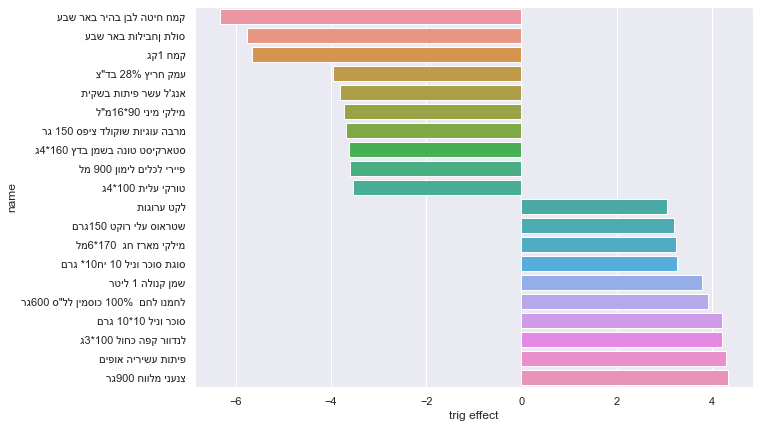

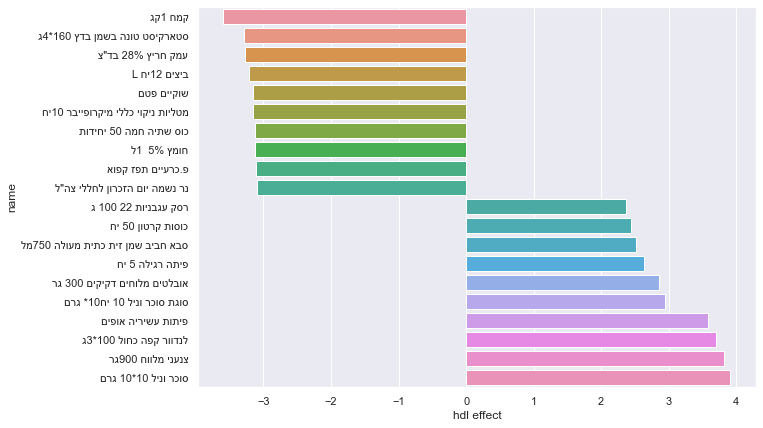

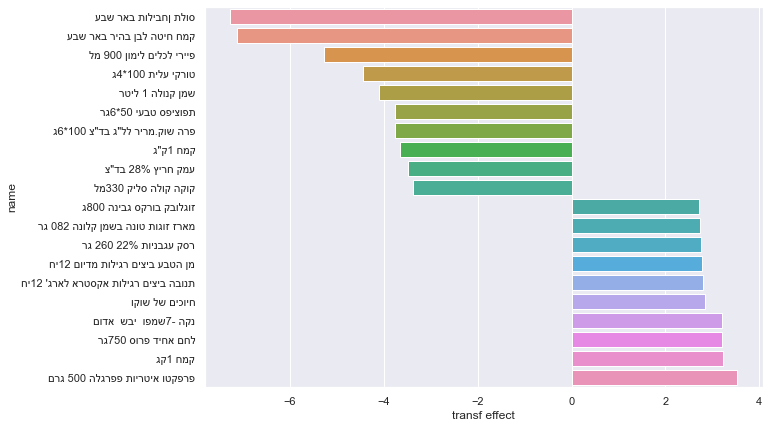

In [11]:
MIN_DIFF = 1
def _region_pairwise_rank():
    for r1, v1 in ranks.items():
        for r2, v2 in ranks.items():
            vec1 = city_embeddings[[x==r1 for x in region_list]].mean(axis=0)
            vec2 = city_embeddings[[x==r2 for x in region_list]].mean(axis=0)
            comparison_X.append(vec1-vec2)
            if np.abs(v1-v2) < MIN_DIFF:
                comparison_y.append(0)
                comparison_X.append(vec1-vec2)
                comparison_y.append(1)
                continue
            comparison_y.append(v1 < v2)
def fit(comparison_X, comparison_y):
    model = LR(C=0.01, max_iter=10000)
    model.fit(comparison_X, comparison_y)
    top_products = [x.barcode for x in Dataset().products if x.usages > 10000]
    return [[Dataset().barcode_to_product[x].name, x, (embeddings_dict[x].dot(model.coef_[0]) - model.intercept_)[0]] for x in top_products]
    
def importance_from_order(order, name):
    order = order.split(' ')
    ranks = {}
    for region in set(user_regions):
        rank = [4-i for i,x in enumerate(order) if x.find(region.split(' ')[0]) != -1][0]
        ranks[region] = rank
    comparison_X = []
    comparison_y = []
    for i, city1 in enumerate(city_list):
        for j, city2 in enumerate(city_list):
            if city1 == city2:
                continue
            vec1 = city_embeddings[i]
            vec2 = city_embeddings[j]
            comparison_X.append(vec1-vec2)
            v1, v2 = ranks[city_to_region[city1]], ranks[city_to_region[city2]]

            if np.abs(v1-v2) < MIN_DIFF:
                comparison_y.append(0)
                comparison_X.append(vec1-vec2)
                comparison_y.append(1)
                continue
            comparison_y.append(v1 < v2)
    data = fit(comparison_X, comparison_y)
    column_name = f'{name} effect'
    
    df = pd.DataFrame(data=data, columns=['item', 'barcode', column_name])
    df['name'] = df.item.map(smart_inverse)
    df = df.sort_values(column_name)
    f = plt.figure(figsize=(10,7))
    p = sns.barplot(y='name', x=column_name, data=df.head(10).append(df.tail(10)))
order = "Jerusalem South Haifa|North Dan|Sharon|Central Tel"
importance_from_order(order, 'trig')

order = 'Jerusalem Sharon|South|North|Haifa Dan|Central Tel'
importance_from_order(order, 'hdl')

order = 'South Jerusalem|Sharon|North Dan|Central Tel|Haifa'
importance_from_order(order, 'transf')



# Attempts to predict socio/religion from sales

In [ ]:
model = Ridge(alpha=0.2)

city_embeddings = np.vstack([embeddings_dict[x] for x in stats_df.index.values])
city_embeddings_normalized = normalize(city_embeddings, axis=1)
for column in ['socio', 'haredim']:
    model.fit(city_embeddings_normalized, stats_df[column].values)
    top_products = [x.barcode for x in Dataset().products if x.usages > 10000]
    column_name = column+' effect'
    socio_df = pd.DataFrame(data=[[Dataset().barcode_to_product[x].name, x, model.predict(embeddings_dict[x].reshape(1, -1))[0] - model.intercept_] for x in top_products], columns=['item', 'barcode', column_name])
    
    socio_df['name'] = socio_df.item.map(smart_inverse)
    socio_df = socio_df.sort_values(column_name)
    f = plt.figure(figsize=(10,7))
    p = sns.barplot(y='name', x=column_name, data=socio_df.head(10).append(socio_df.tail(10)))
    p.set_title('Estimated ' + column +' correlation')
    print(column, 'R squared',model.score(city_embeddings_normalized, stats_df[column].values), 'MAE',   mean_squared_error(model.predict(city_embeddings_normalized), stats_df[column].values, squared=False))

In [57]:
user_embeddings = np.vstack([embeddings_dict[x] for x in Users().active_users])
user_embeddings_normalized = normalize(user_embeddings, axis=1)
model.fit(city_embeddings, stats_df['socio'].values)
user_socio = model.predict(user_embeddings)
model.fit(city_embeddings, stats_df['haredim'].values)
user_religion = model.predict(user_embeddings)

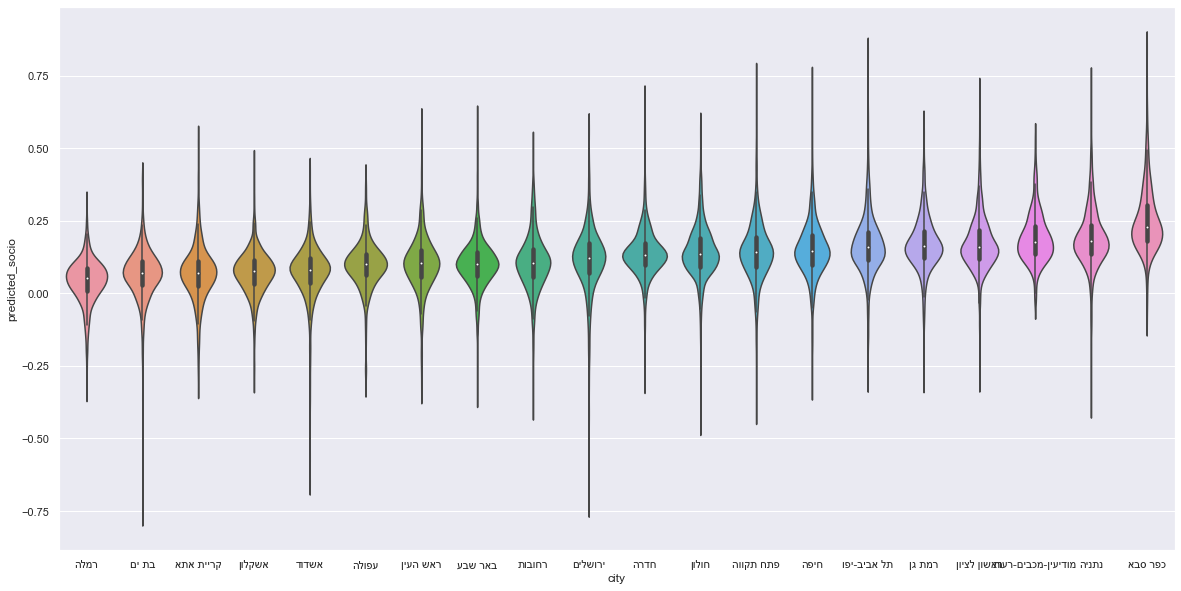

In [24]:
model = Ridge(alpha=0.2)
model.fit(city_embeddings, stats_df['socio'].values)
example_cities = list(stats_df.sort_values('n_users').index.values[-20:])
example_city_socio = stats_df.loc[example_cities]['socio'].values
city_users = [[x, smart_inverse(y), model.predict(embeddings_dict[x].reshape(1,-1))[0]]  for x,y in Users().active_users_cities.items() if y in example_cities]
df = pd.DataFrame(city_users, columns=['u_id', 'city', 'predicted_socio'])
plt.figure(figsize=(20,10))
p = sns.violinplot(x='city', y='predicted_socio', data=df, order=df.groupby('city')['predicted_socio'].mean().sort_values().index)
#for i in range(20):
    #p.plot([i-0.5,i+0.5], [v[i], v[i]])

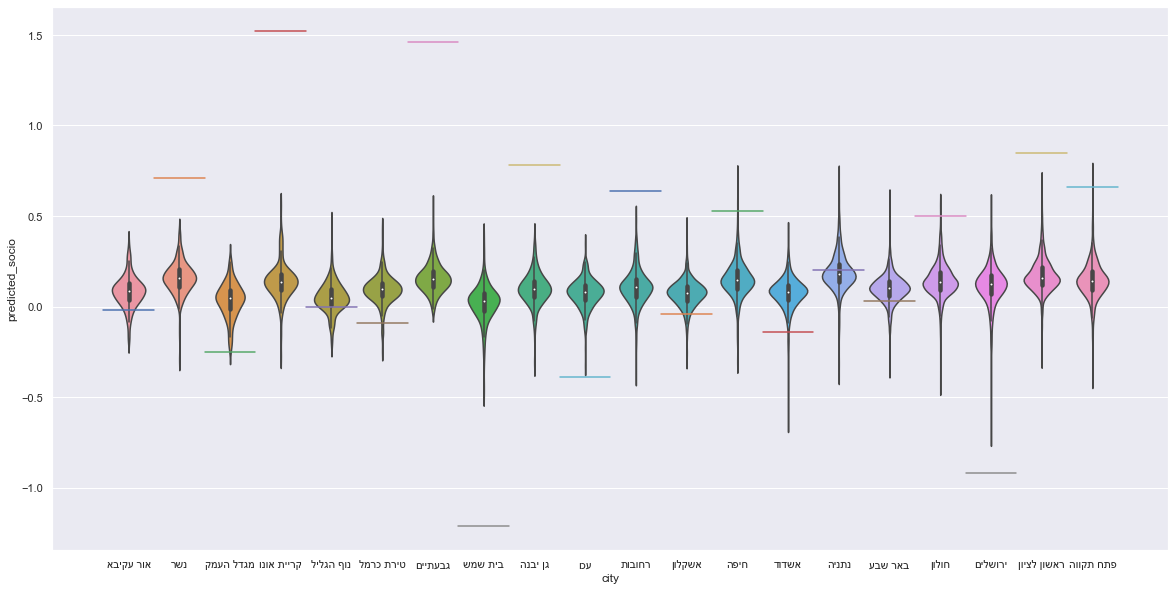

In [25]:
model = Ridge(alpha=0.2)
model.fit(city_embeddings, stats_df['socio'].values)
example_cities = list(stats_df.sort_values('n_users').index.values[-50:-40])+ list(stats_df.sort_values('n_users').index.values[-10:])
example_city_socio = stats_df.loc[example_cities]['socio'].values
city_users = [[x, smart_inverse(y), model.predict(embeddings_dict[x].reshape(1,-1))[0]]  for x,y in Users().active_users_cities.items() if y in example_cities]
df = pd.DataFrame(city_users, columns=['u_id', 'city', 'predicted_socio'])
plt.figure(figsize=(20,10))
p = sns.violinplot(x='city', y='predicted_socio', data=df, order=[smart_inverse(x) for x in example_cities])
for i in range(20):
    p.plot([i-0.5,i+0.5], [example_city_socio[i], example_city_socio[i]])

# User clustering and explaining

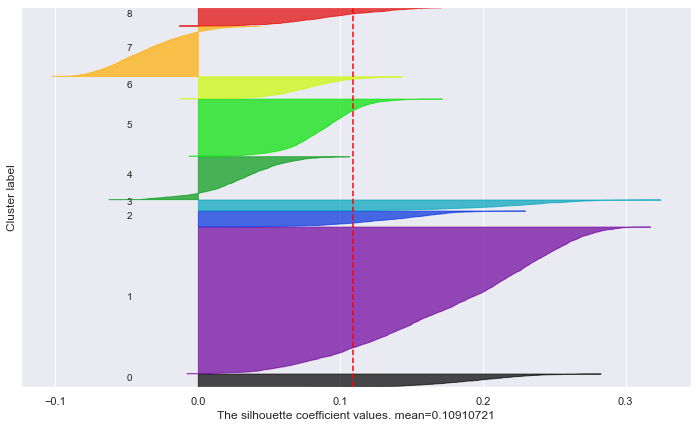

In [26]:
def viz_silhoette(X, cluster_labels, title='', ax=None):
    if X.shape[0] > 10000:
        idx = np.random.choice(X.shape[0], size=10000, replace=False)
        X = X[idx]
        cluster_labels = cluster_labels[idx]
    
    n_clusters = len(set(cluster_labels))
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    if ax is None:
        f, ax1 = plt.subplots(1,1, figsize=(12,7))
    else:
        ax1 = ax
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(title)
    ax1.set_xlabel("The silhouette coefficient values. mean=" +str(np.mean(sample_silhouette_values)))
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=np.mean(sample_silhouette_values), color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    
    if ax is None:
        plt.show()


clf = MiniBatchKMeans(n_clusters=9, random_state=4)
#clf = GaussianMixture(n_components=5, random_state=3)
user_clusters = clf.fit_predict(user_embeddings_normalized)
viz_silhoette(user_embeddings_normalized, user_clusters)

<AxesSubplot:xlabel='n_clusters', ylabel='silhoette'>

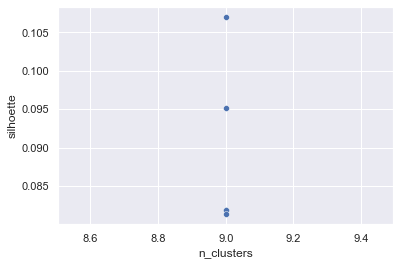

In [23]:
res = []
for k in range(9,11,2):
    for restart in range(5):
        clf = MiniBatchKMeans(n_clusters=k, random_state=restart)
    #clf = GaussianMixture(n_components=10, random_state=3)
        y = clf.fit_predict(user_embeddings_normalized)
        res.append([k, silhouette_score(user_embeddings_normalized, y)])
sns.scatterplot(x='n_clusters', y='silhoette', data=pd.DataFrame(data=res, columns=['n_clusters', 'silhoette']))

In [83]:
%%time
LOAD_VECS = True
if LOAD_VECS:
    with open(CLUSTERING_PATH, 'rb') as f:
        user_vectors = pickle.load(f)
else:
    #user_vectors = {u: np.zeros(sum(LEVEL_SIZE[:-1])) for u in {x.user_id for x in transactions}}
    user_vectors = {u: np.zeros(Dataset().hierarchy_sizes[-2]) for u in Users().active_users}
    offset = sum(Dataset().hierarchy_sizes[:-2])
    for t in Dataset().transactions:
        if t.user_id not in user_vectors.keys():
            continue
        user_vectors[t.user_id][[Dataset().barcode_to_product[barcode].hierarchy_indices[3]-offset for barcode in t.barcodes]] += 1
        #user_vectors[t.user_id][p.hierarchy_indices[:min(p._representation+1, 4)]] += 1
    with open(CLUSTERING_PATH, 'wb') as f:
        pickle.dump(user_vectors, f)

tf_matrix = np.vstack([user_vectors[x] for x in Users().active_users])  
tf_normalized = normalize(tf_matrix, axis=1, norm='l2')

del user_vectors

Wall time: 8.19 s


In [95]:
l3 = sorted([x for x in Dataset().index_of.keys() if x.startswith('3_')])
feature_names = [x[2:].replace('[', '(').replace(']', ')').replace('<', ' ') for x in l3]
df = pd.DataFrame(data=tf_normalized, columns=feature_names)
#

from sklearn.utils import resample
def split(cluster, np_array=False):
    X_train, X_test, y_train, y_test = train_test_split(df, [z==cluster for z in user_clusters], test_size=0.20, random_state=1)
    if X_train.shape[0] > sum(y_train)*2:
        z_df = X_train[[not x for x in y_train]]
        z_df = resample(z_df, n_samples=sum(y_train)*2, random_state=1)
        X_train = X_train[y_train].append(z_df)
        y_train = np.array([1]*(len(X_train) - len(z_df)) +[0]*len(z_df))
    # for the tests
    #X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=1)
    if np_array:
        return X_train.values, X_test.values, y_train, y_test
    return X_train, X_test, y_train, y_test

def viz_lr_mixed(cluster=0, k=20, positive=12):
    X_train, X_test, y_train, y_test = split(cluster, True)
    model = LR(max_iter=10000, penalty='l2', solver='liblinear', class_weight='balanced', C=100)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    f1 = recall_score(y_test, predictions)
    positive_weights = X_train[y_train].mean(axis=0)*model.coef_[0]
    negative_weights = X_train[~y_train].mean(axis=0)*model.coef_[0]
    tmp = pd.DataFrame(sorted(list(zip(positive_weights, feature_names)), key=lambda x: x[0], reverse=True)[:positive], columns=['Logistic regression weight', 'sub-category'])
    tmp2 = pd.DataFrame(sorted(list(zip(negative_weights, feature_names)), key=lambda x: x[0], reverse=True)[-(k-positive):], columns=['Logistic regression weight', 'sub-category'])
    tmp = tmp.append(tmp2)
    tmp['sub-category'] = tmp['sub-category'].map(smart_inverse)
    f = plt.figure(figsize=(10,7))
    p = sns.barplot(y='sub-category', x='Logistic regression weight', data=tmp)
    
    socio = user_socio[y_train].mean()
    rel = user_religion[y_train].mean()
    p.set_title('Cluster {} with {:.1f}% of users. Recall: {:.1f}%. Socio status: {:.2f}. Predicted haredim rate: {:.2f}'.format(cluster, sum(y_train)/len(df)*100,f1*100, round(socio, 2), round(rel, 2)))
    plt.savefig('./img/'+str(cluster)+'.png')
    

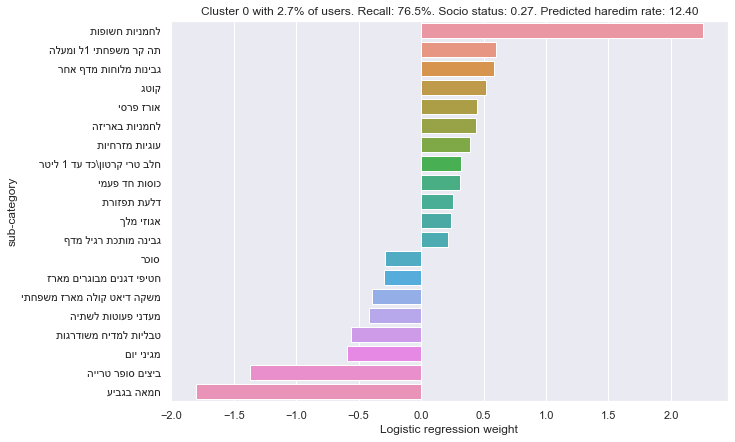

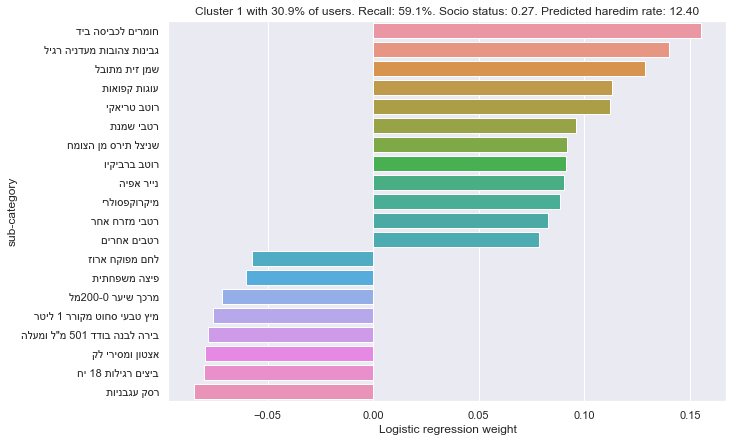

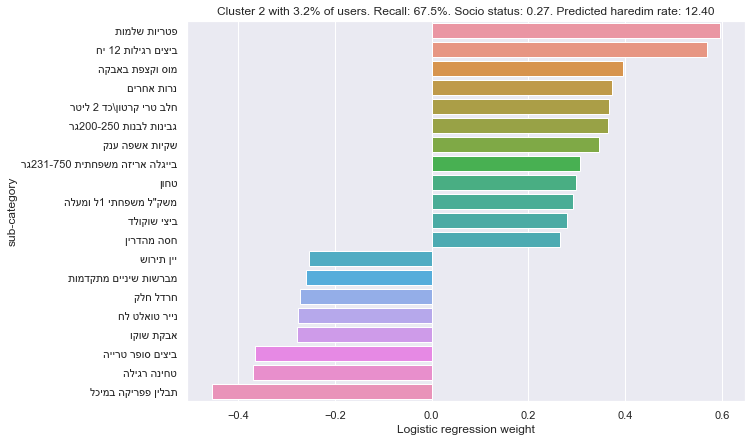

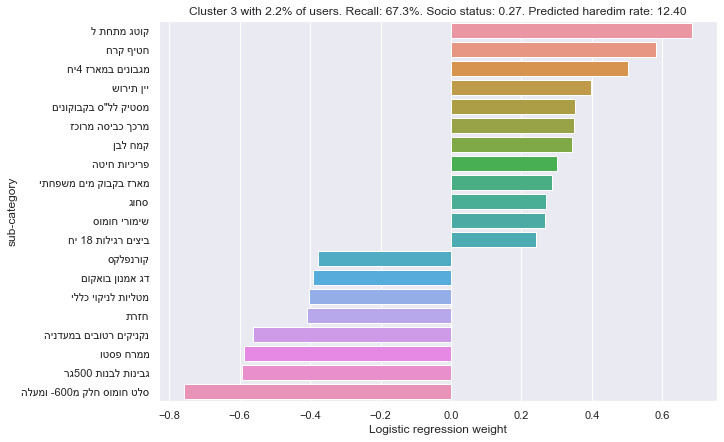

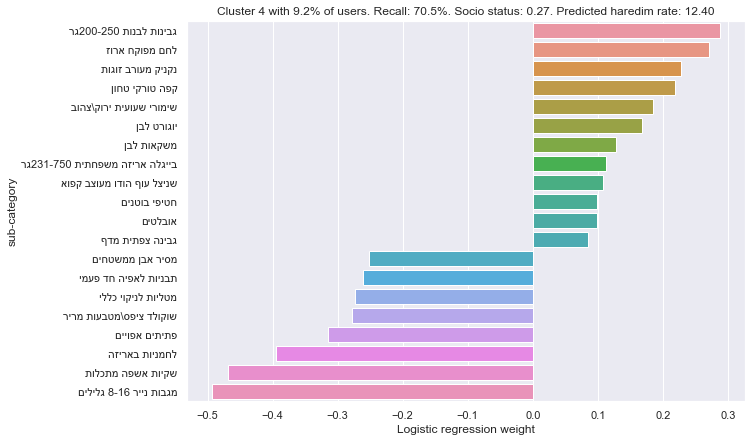

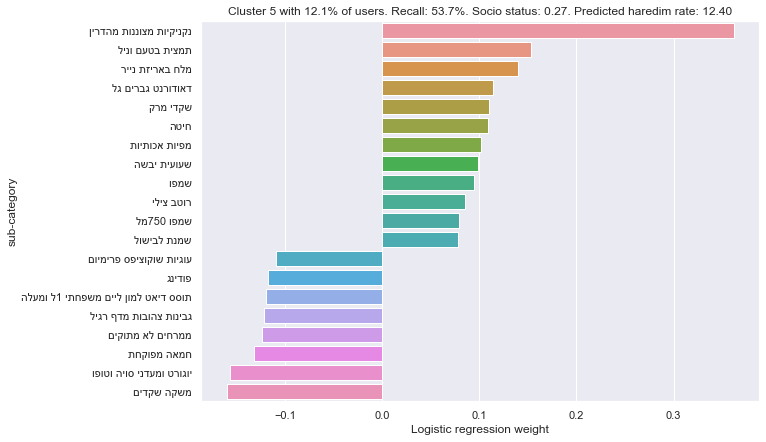

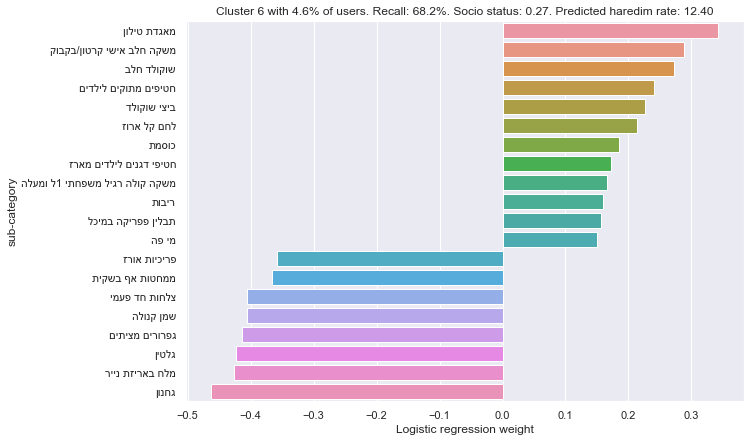

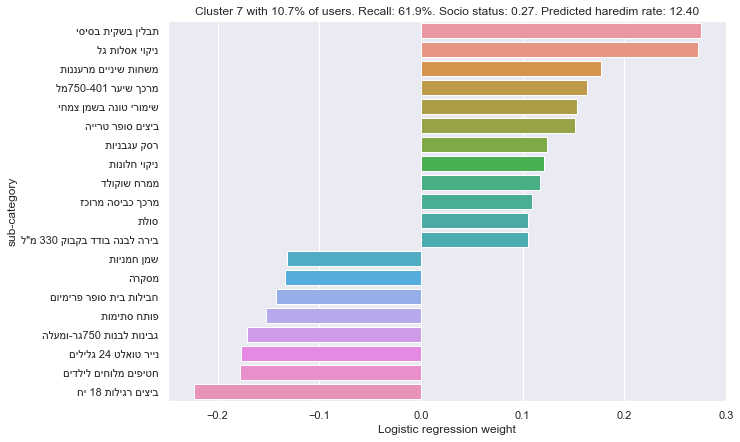

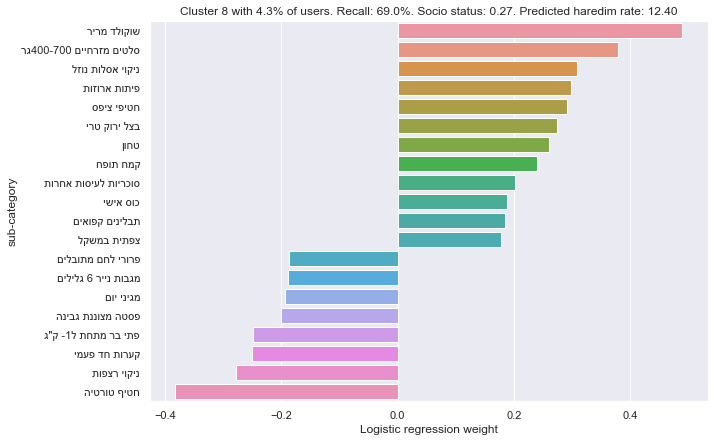

In [97]:
for i in range(9):
    viz_lr_mixed(i)

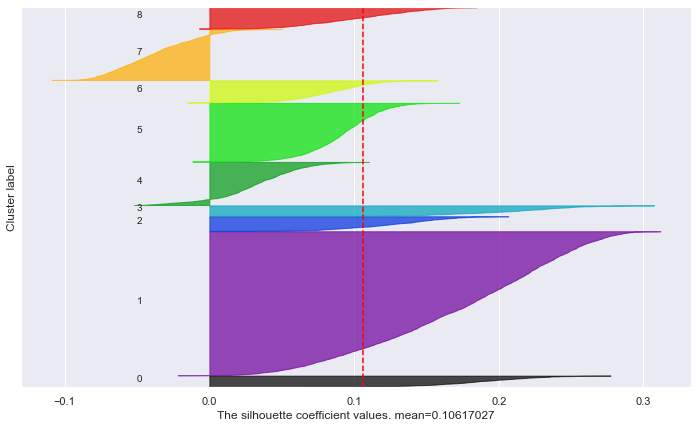

In [51]:
viz_silhoette(user_embeddings_normalized, user_clusters)

In [55]:
viz_lr_mixed(i, 20, 12)

ValueError: Found array with 0 sample(s) (shape=(0, 1444)) while a minimum of 1 is required.

In [82]:

def viz_explanation(cluster=0):
    X_train, X_test, y_train, y_test = split(cluster)
    hist = ClassHistogram().explain_data(X_train, y_train, name = 'Train Data')

    ebm = ExplainableBoostingClassifier(random_state=1, n_jobs=8, interactions=0, max_bins=30)
    ebm.fit(X_train, y_train)   #Works on dataframes and numpy arrays
    ebm_global = ebm.explain_global(name='EBM')
    ebm_local = ebm.explain_local(X_test[y_test][:5].append(X_test[y_test].mean(), ignore_index=True), [1]*6, name='EBM') #first 5 positive instances and cluster center as 6th one
    ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='EBM')
    lr = LogisticRegression(random_state=1, feature_names=feature_names, penalty='l1', solver='liblinear', C=1)
    lr.fit(X_train, y_train)
    #sorted(zip(lr.sk_model_.coef_[0], feature_names), key=lambda x: x[0], reverse=True)[:10]
    lr_perf = ROC(lr.predict_proba).explain_perf(X_test, y_test, name='Logistic Regression')

    lr_global = lr.explain_global(name='Logistic Regression')
    lr_local = lr.explain_local(X_test[y_test][:5].append(X_test[y_test].mean(), ignore_index=True), [1]*6, name='LR local' )
    
    show([hist, lr_global, lr_perf, ebm_global, ebm_perf, ebm_local, lr_local], share_tables=True)

def viz_shap(cluster=0):
    X_train, X_test, y_train, y_test = split(cluster, True)
    model = XGBClassifier(use_label_encoder=False) 
    #model = sklearn.linear_model.LogisticRegression(max_iter=100, penalty='l1', solver='liblinear')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(cluster, accuracy_score(y_test, predictions), recall_score(y_test, predictions))
    X_train = pd.DataFrame(X_train)
    X_train.columns = [x[::-1] for x in feature_names] if DATASET == 'strauss' else feature_names
    explainer = shap.Explainer(model, X_train)
    shap.initjs()
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)
    
def viz_lr(cluster=0, viz_center=False, k=20, positive=15):
    X_train, X_test, y_train, y_test = split(cluster, True)
    model = LR(max_iter=100, penalty='l1', solver='liblinear')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(accuracy_score(y_test, predictions), recall_score(y_test,predictions), precision_score(y_test, predictions))
    if viz_center:
        weights = X_train[y_train].mean(axis=0)*model.coef_[0]
    else:
        weights = model.coef_[0]
    named_coef = list(zip(weights, feature_names))
    tmp = pd.DataFrame(sorted(named_coef, key=lambda x: x[0], reverse=True), columns=['Logistic regression weight', 'sub-category'])
    return tmp.head(positive).append(tmp.tail(k-positive))

def create_lists(cluster=0):
    X_train, X_test, y_train, y_test = split(cluster)
    cluster_center = X_train.iloc[y_train].mean(axis=0)
    
    #ebm = ExplainableBoostingClassifier(random_state=1, n_jobs=8, interactions=0, max_bins=30)
    #ebm.fit(X_train, y_train)
    #ebm_list = []
    
    model = XGBClassifier(use_label_encoder=False) 
    model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer(X_train.append(cluster_center, ignore_index=True))
    shap_aggregated = shap_values[:-1,:][y_train,:].mean(axis=0).values
    
    shap_center = shap_values[-1,:]
    
    lr = LR(max_iter=100, penalty='l1', solver='liblinear')
    lr.fit(X_train, y_train)
    lr_prediction = X_train.values[y_train].mean(axis=0)*lr.coef_[0]
    lr_weights = lr.coef_[0]
    
    return shap_aggregated, shap_center.values, lr_prediction, lr_weights

def rank_to_score(rank, l):
    return len(l)-rank-1

def aggregate_lists(lists, method='rank'):
    if method == 'score':
        stacked_scores = np.stack(lists).T
        norm_scores = sklearn.preprocessing.StandardScaler().fit_transform(stacked_scores)
        new_scores = norm_scores.mean(1)
        return new_scores
    
    scores = np.zeros(len(lists[0]))
    for l in lists:
        list_scores = Counter(np.abs(l))
        less_than = {sc: sum([v for k,v in list_scores.items() if k < sc ]) for sc in list_scores.keys()}
        for i, v in enumerate(np.abs(l)):
            scores[i] += less_than[v]
            
    for i in range(len(lists[0])):
        if all(l[i] >= 0 for l in lists):
            continue
        elif all(l[i] <= 0 for l in lists):
            scores[i] = -scores[i]
        else:
            scores[i]=0
    return scores

def top_k_features(scores, k=20, positive=15):
    best = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    best = [(feature_names[i], scores[i]) for i in best]
    return best[:positive] + best[-(k-positive):]


<!-- http://127.0.0.1:7001/1051234356360/ -->
 Open in new window